In [1]:
import numpy as np
import mrcfile
from matplotlib import pyplot as plt
%matplotlib inline
import collections
import tensorflow as tf
from tensorflow import spectral
from ClassFiles.relion_fixed_it import load_star
from ClassFiles.AdversarialRegularizer import AdversarialRegulariser
from ClassFiles.ut import l2
from ClassFiles.Utilities import registration
from ClassFiles.ut import locate_gt, rfft, irfft, unify_form, Rescaler

In [2]:
# saves_path = '/local/scratch/public/sl767/SPA/Saves/Adversarial_Regulariser/AllData/AllAugmentation'
saves_path = '/local/scratch/public/sl767/SPA/Saves/Adversarial_Regulariser/Cutoff_20/Translation_Augmentation'
regularizer = AdversarialRegulariser(saves_path)

INFO:tensorflow:Restoring parameters from /local/scratch/public/sl767/SPA/Saves/Adversarial_Regulariser/Cutoff_20/Translation_Augmentation/Data/model-20000
Save restored


In [3]:
Registrator = registration.LocalRegistrator()

/alt/applic/user-maint/sl767/miniconda3/envs/py3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [4]:
def l2_gt(x):
    image=unify_form(np.copy(x))
    r=Rescaler(image)
    r.normalize(image)
    reg=Registrator.register(image=image, reference=ground_truth)
    return l2(reg-ground_truth)

In [5]:
def vis(data, fourier=True):
    if fourier:
        data = irfft(data)
    plt.imshow(data.squeeze()[...,45])
#     plt.imshow(np.mean(data.squeeze(), axis=-1))

In [17]:
NOISE_LEVEL = '016'
ITERATION = '03'
METHODE = 'EM'
PDB_ID = '5A0M'

In [18]:
base_path = '/local/scratch/public/sl767/MRC_Data/Data/Data_0{n}_10k/eval/{m}/{PDB}/'
path=base_path+'{PDB}_mult0{n}_it0{i}_half2_class001_external_reconstruct.star'
path = path.format(n=NOISE_LEVEL, m=METHODE, PDB = PDB_ID, i=ITERATION)

In [19]:
file=load_star(path)

In [20]:
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataReal']) as mrc:
    data_real = mrc.data.copy()
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsDataImag']) as mrc:
    data_im = mrc.data.copy()
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsWeight']) as mrc:
    kernel = mrc.data.copy()
with mrcfile.open(locate_gt(PDB_ID, full_path=False)) as mrc:
    ground_truth = mrc.data.copy()
with mrcfile.open(file['external_reconstruct_general']['rlnExtReconsResult']) as mrc:
    naive_recon = mrc.data.copy()
    
ground_truth = unify_form(ground_truth)
r_gt = Rescaler(ground_truth)
r_gt.normalize(ground_truth)

complex_data=data_real + 1j * data_im

5.25681e+07 1e+06
52.5681


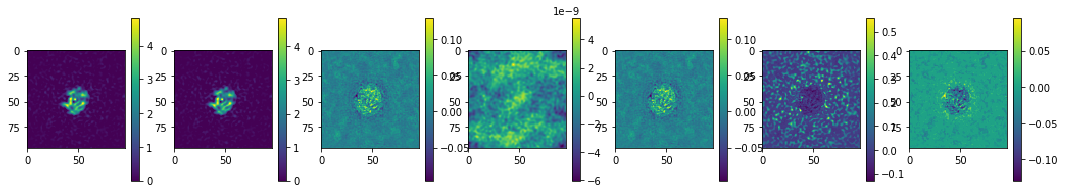

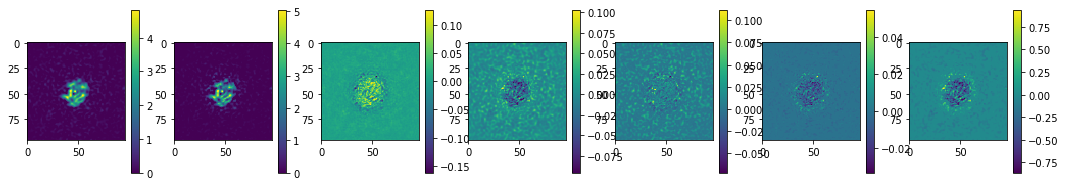

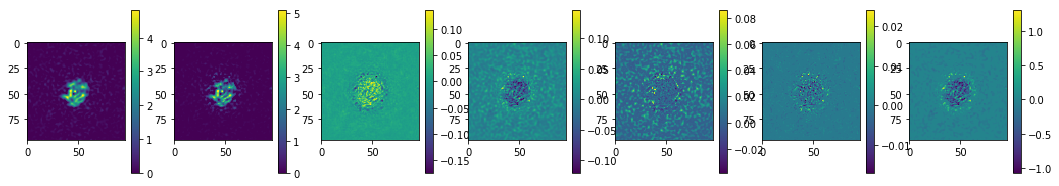

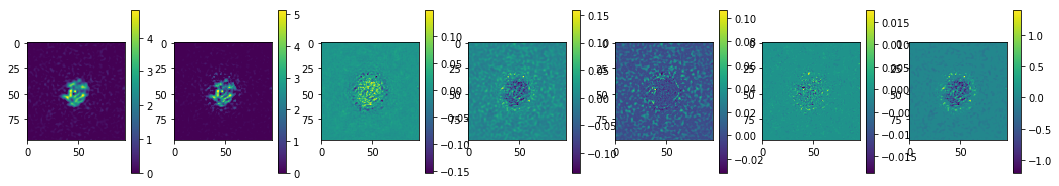

In [23]:
REG = 0.03
    
tikhonov_kernel = kernel + 1e6
print(tikhonov_kernel.max(),tikhonov_kernel.min())
precondioner = np.abs(np.divide(1, tikhonov_kernel))
precondioner /= precondioner.max()
print(precondioner.max()/precondioner.min())
tikhonov = np.divide(complex_data, tikhonov_kernel)
reco = np.copy(tikhonov)

# The scales produce gradients of order 1
ADVERSARIAL_SCALE=(96**(-0.5))
DATA_SCALE=1/(10*96**3)

IMAGING_SCALE=96

for k in range(50):
    STEP_SIZE=1.0 * 1 / np.sqrt(1 + k / 20)
    
    gradient = regularizer.evaluate(reco)
    g1 = REG * gradient * ADVERSARIAL_SCALE
#     print(l2(gradient))
    g2 = DATA_SCALE*(np.multiply(reco, tikhonov_kernel) - complex_data)
    
    g = g1 + g2
#     reco = reco - STEP_SIZE * 0.02 * g
    
    reco_o = np.copy(reco)
    reco = reco - STEP_SIZE * precondioner * g
    
    reco = np.fft.rfftn(np.maximum(0, np.fft.irfftn(reco)))
        
    #reco = reco - STEP_SIZE*(g1 + g2 + g3)
    if k%15==0:
        plt.figure(k, figsize=(18,3))
        plt.subplot(171)
        vis(IMAGING_SCALE*np.fft.rfftn(np.maximum(0, np.fft.irfftn(tikhonov))))
        plt.colorbar()
        plt.subplot(172)
        vis(IMAGING_SCALE*reco)
        plt.colorbar()
        plt.subplot(173)
        vis(IMAGING_SCALE*precondioner*g1)
        plt.colorbar()
        plt.subplot(174)
        vis(IMAGING_SCALE*precondioner*g2)
        plt.colorbar()
        plt.subplot(175)
        vis(IMAGING_SCALE*precondioner*(g1+g2))
        plt.colorbar()
        plt.subplot(176)
        vis(IMAGING_SCALE*(reco-reco_o))
        plt.colorbar()
        plt.subplot(177)
        vis(IMAGING_SCALE*(reco - np.fft.rfftn(np.maximum(0, np.fft.irfftn(tikhonov)))))
        plt.colorbar()
        plt.show()

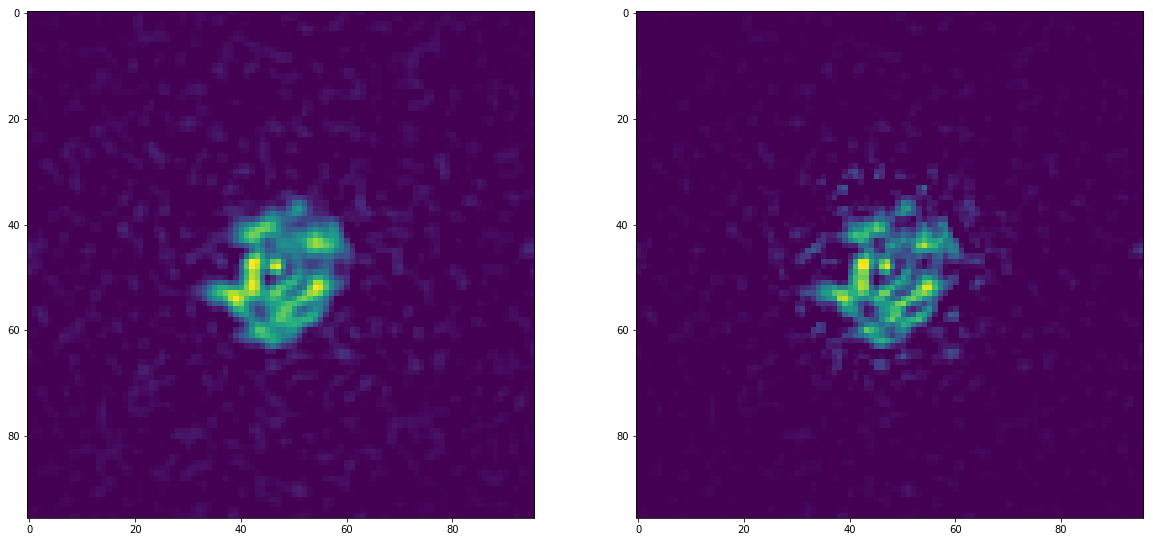

In [24]:
plt.figure(figsize=(20,20))
plt.subplot(121)
vis(np.fft.rfftn(np.maximum(0, np.fft.irfftn(tikhonov))))
plt.subplot(122)
vis(reco)

In [38]:
def evaluate(reg):
    tikhonov_kernel = kernel + 1e6
    precondioner = np.abs(np.divide(1, tikhonov_kernel))
    precondioner /= precondioner.max()
    tikhonov = np.divide(complex_data, tikhonov_kernel)
    reco = np.copy(tikhonov)

    # The scales produce gradients of order 1
    ADVERSARIAL_SCALE=(96**(-0.5))
    DATA_SCALE=1/(10*96**3)

    IMAGING_SCALE=96

    for k in range(70):
        STEP_SIZE=1.0 * 1 / np.sqrt(1 + k / 20)

        gradient = regularizer.evaluate(reco)
        g1 = reg * gradient * ADVERSARIAL_SCALE
    #     print(l2(gradient))
        g2 = DATA_SCALE*(np.multiply(reco, tikhonov_kernel) - complex_data)

        g = g1 + g2
    #     reco = reco - STEP_SIZE * 0.02 * g
        reco = reco - STEP_SIZE * precondioner * g

        reco = np.fft.rfftn(np.maximum(0, np.fft.irfftn(reco)))
    return l2_gt(irfft(reco))

In [39]:
parameters = [0.0, 0.01, 0.02, 0.03]
results = {}
for reg in parameters:
    results['Reg_{}'.format(reg)] = evaluate(reg = reg)

0.62824
0.662936
0.627217
0.623932
0.616257
Final Registration Loss: 0.61623
Rotation: 
[[[ 0.9998363  -0.01735905  0.00510456]
  [ 0.01736828  0.9998476  -0.00176927]
  [-0.00507307  0.00185764  0.9999854 ]]]
Translation: 
[[[ -5.61368593e-04]
  [  2.01698334e-04]
  [ -9.75139119e-05]]]
0.597219
0.609682
0.600514
0.598407
0.589595
Final Registration Loss: 0.586872
Rotation: 
[[[ 0.9998215  -0.0153744   0.01098346]
  [ 0.01534631  0.9998787   0.00263784]
  [-0.01102268 -0.00246882  0.9999362 ]]]
Translation: 
[[[-0.00044205]
  [ 0.00068595]
  [ 0.00081336]]]
0.575556
0.591633
0.569457
0.569543
0.563753
Final Registration Loss: 0.563564
Rotation: 
[[[  9.99880493e-01  -1.23681026e-02   9.27626807e-03]
  [  1.23685943e-02   9.99923468e-01   4.42993542e-06]
  [ -9.27561242e-03   1.10304980e-04   9.99957025e-01]]]
Translation: 
[[[-0.0008305 ]
  [ 0.00117793]
  [ 0.00072545]]]
0.569267
0.573219
0.571954
0.560641
0.553419
Final Registration Loss: 0.550542
Rotation: 
[[[ 0.9997758  -0.016082

In [41]:
print(results)

{'Reg_0.0': 0.76777601, 'Reg_0.01': 0.75016302, 'Reg_0.02': 0.73601866, 'Reg_0.03': 0.7283532}


# Optimal parameters:

- SNR .02, first iterate: .03 --> Improvement .015
- SNR .02, 10th iterate: .05 --> Improvement .081
- SNR .01, first iterate: .005 (reasonable till .01) --> Improvement .002
- SNR .01, 10th: .005 (reasonable till .01) --> Improvement .002
- SNR .012, first iterate: .01 --> Improvement .006
- SNR .012, 10th iterate: .01 --> Improvement .006
- SNR .016, first iterate: .02 --> Improvement .012
- SNR .016, 10th: .03 --> Improvement .042

In [15]:
for l, item in res1.items():
    print(l)
    print(item)

Reg_0.0
0.926861
Reg_0.001
0.926727
Reg_0.002
0.926671
Reg_0.005
0.926822
Reg_0.01
0.928034


# Results for 10th iterate, SNR .01

In [25]:
for l, item in results.items():
    print(l)
    print(item)

Reg_0.0
0.96947
Reg_0.001
0.968683
Reg_0.002
0.968957
Reg_0.005
0.968748
Reg_0.01
0.968847
Reg_0.02
0.972109
Reg_0.05
1.00863


# Results for 01st iterate, SNR .02

In [32]:
for l, item in results.items():
    print(l)
    print(item)

Reg_0.0
0.786947
Reg_0.001
0.78646
Reg_0.002
0.785675
Reg_0.005
0.784036
Reg_0.01
0.782251
Reg_0.02
0.78097
Reg_0.05
0.793211


# Results for 10th iterate, SNR .02

In [42]:
for l, item in results.items():
    print(l)
    print(item)

Reg_0.0
0.629159
Reg_0.001
0.62979
Reg_0.002
0.626202
Reg_0.005
0.624027
Reg_0.01
0.618987
Reg_0.02
0.610808
Reg_0.05
0.60086
